# Mansi Parikh - NYT DS Assignment 

Create a model that attempts to predict the optimal number of newspapers to deliver (aka "draw") for each day during the week starting on January 01-2015.

Observations:
I am seeing about 1% of values in the 'sold' column to be negatives. Additionally, >50% of the 'sold' counts is 0 which is why you will notice that I've built the feature set using the 'draws'. I will also demonstrate that both columns are correlated to justify the decision. 

Justification for not using the bipad feature in this sample: 
- The 'bipad' column only has a single edition. 
- the date is consistent with the bipad date (timestamp + 1). 
- 900 is a constant 

Due to the nature of the dataset, I have decided to use linear regression for my model to explore relationship between variables like day, weekday, month, unsold count.  

Todo for future iterations: 
1. Explore the feature set in depth to understand the importance of each feature. Current model implements all available features. 
2. Test for more sophisticated models like Lasso, Ridge etc. 
3. Optimize for profit instead of accuracy. 


In [1]:
from pandas import DataFrame as df
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from patsy import dmatrices
from sklearn.model_selection import TimeSeriesSplit

In [2]:
read_file = df.from_csv('homework_singlecopy.tsv', sep='\t', index_col=0, parse_dates=True )
read_file.head()

,account,bipad,draws,sold
date,,,,
2014-01-06,1,90016,3,1
2014-01-13,1,90016,2,2
2014-01-20,1,90016,4,0
2014-01-27,1,90016,10,5
2014-01-07,1,90026,5,3


In [3]:
read_file.describe()

,account,bipad,draws,sold
count,34767.000000,34767.000000,34545.000000,34546.000000
mean,49.877528,90045.643340,3.078622,0.983616
std,29.168497,19.909605,2.882345,1.624611
min,1.000000,90016.000000,0.000000,-15.000000
25%,24.000000,90026.000000,1.000000,0.000000
50%,49.000000,90046.000000,2.000000,-0.000000
75%,76.000000,90066.000000,4.000000,1.000000
max,100.000000,90076.000000,57.000000,18.000000


In [4]:
# normalize for missing values and negative values 
read_file = read_file.fillna(method='pad') #fill missing values forward
read_file[read_file < 0] = 0

# add some more features to do exploratory analysis 
read_file['day_of_week'] = read_file.index.dayofweek #0=sunday
read_file['month'] = read_file.index.month
read_file['week_of_month'] = (read_file.index.day - 1)//7+1
read_file['day'] = (pd.DatetimeIndex(read_file.index) + pd.DateOffset(1)).day
read_file['wasted_draws'] = read_file.draws - read_file.sold
read_file.head()

,account,bipad,draws,sold,day_of_week,month,week_of_month,day,wasted_draws
date,,,,,,,,,
2014-01-06,1,90016,3,1,0,1,1,7,2
2014-01-13,1,90016,2,2,0,1,2,14,0
2014-01-20,1,90016,4,0,0,1,3,21,4
2014-01-27,1,90016,10,5,0,1,4,28,5
2014-01-07,1,90026,5,3,1,1,1,8,2


In [5]:
sold_draws = read_file.groupby(['day_of_week'])['sold', 'draws'].sum()
sold_draws['pct_sold'] = sold_draws['sold'] / sold_draws['draws']
sold_draws

,sold,draws,pct_sold
day_of_week,,,
0,3801,13909,0.273276
1,4417,14987,0.294722
2,3910,14485,0.269934
3,4367,14652,0.298048
4,4669,14906,0.313230
5,4140,13784,0.300348
6,9728,20197,0.481656


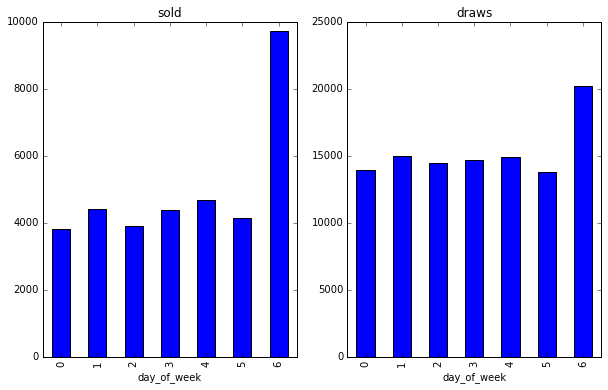

In [6]:
%matplotlib inline
fig, axs = plt.subplots(1,2)

sold_by_day_of_week = read_file.groupby(['day_of_week'])['sold'].sum().plot(kind='bar', figsize=(10, 6),ax=axs[0], title='sold')
draws_by_day_of_week = read_file.groupby(['day_of_week'])['draws'].sum().plot(kind='bar', figsize=(10, 6), ax=axs[1], title='draws')


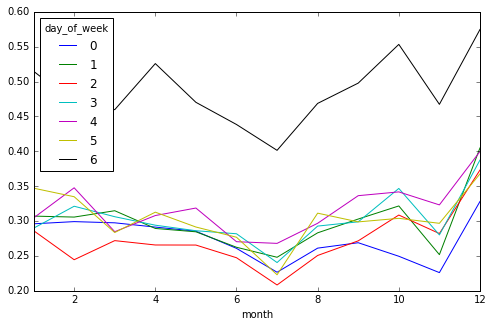

In [8]:
sold_by_day_by_month = read_file.groupby(['month', 'day_of_week'])['sold'].sum().unstack(level=1)
draws_by_day_by_month = read_file.groupby(['month', 'day_of_week'])['draws'].sum().unstack(level=1)

pct_sold_by_month = sold_by_day_by_month / draws_by_day_by_month
pct_sold_by_month.plot(figsize=(8, 5))

# Shows that the weekday trends are somewhat consistant month over month. 
#This justifies our decision to use linear regression for our model. 

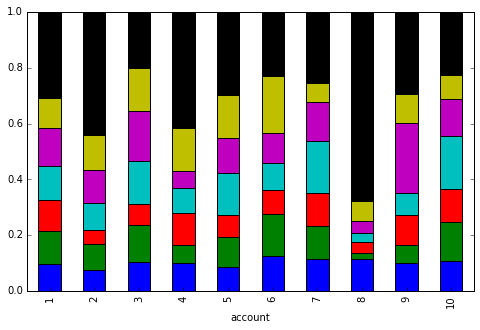

In [9]:
sold_by_day_by_account = read_file.groupby(['account', 'day_of_week'])['sold'].sum().unstack(level=1)
sold_by_day_by_account['sum'] = sold_by_day_by_account.sum(axis=1)
sold_by_day_by_account = sold_by_day_by_account.loc[:].div(sold_by_day_by_account["sum"], axis=0)
if 'sum' in sold_by_day_by_account:
    del sold_by_day_by_account['sum']
sold_by_day_by_account[:10].plot(kind='bar', stacked=True, legend=False, figsize=(8, 5))
# Shows the distribution of weekday delivery volume 

In [10]:
# build feature set 
new_columns = ['account', 'draws', 'sold', 'day_of_week', 'week_of_month', 'day', 'wasted_draws']
data = read_file[new_columns]

/Users/mansi/angel-env/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


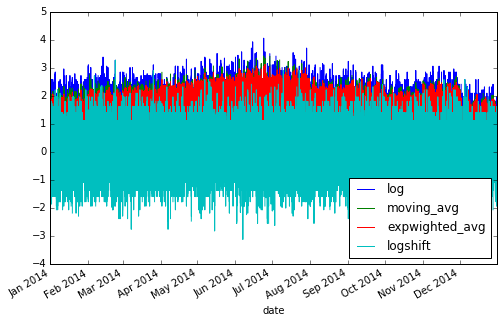

In [11]:
# buiding the feature set on draws because 'sold' column is too sparse. 
data['log'] = np.log(data['draws'])
data['moving_avg']= pd.rolling_mean(data['log'],5)
data['expwighted_avg'] = pd.ewma(data['log'], halflife=5)
data['logshift'] = data['log'] - data['log'].shift()

data[['log', 'moving_avg', 'expwighted_avg', 'logshift']].plot(figsize=(8, 5))

In [12]:
y, X = dmatrices('sold ~ day_of_week + week_of_month + account + log + expwighted_avg + moving_avg + wasted_draws', data=data, return_type="dataframe")
y = np.ravel(y)
X.columns

Index([u'Intercept', u'day_of_week', u'week_of_month', u'account', u'log',
       u'expwighted_avg', u'moving_avg', u'wasted_draws'],
      dtype='object')

In [13]:
from sklearn.linear_model import LinearRegression
reg_model = LinearRegression()
reg_model = reg_model.fit(X, y)
reg_model.score(X, y) # 79% 

0.64776081287609655

In [14]:
# validate our model against historical data
#X = X.reset_index()

if 'date' in X:
    del X['date']

tscv = TimeSeriesSplit(n_splits =2)
for train, test in tscv.split(X):
    X_train, X_test = X[:len(train)], X[len(train): (len(train)+len(test))]
    y_train, y_test = y[:len(train)], y[len(train): (len(train)+len(test))]


reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
reg_model.score(X_test, y_test)

0.65714154995598151

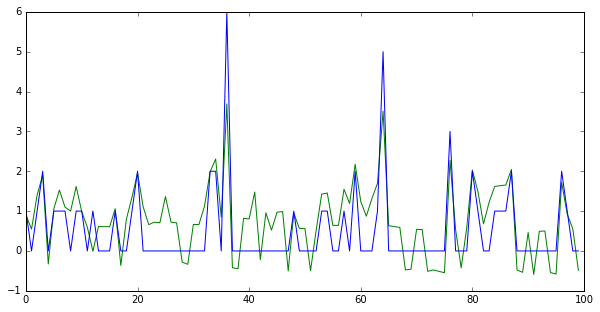

In [15]:
y_pred = reg_model.predict(X_test)

#show the forecasted value with the original value. 
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.plot(y_pred[:100], color='green')
plt.plot(y_test[:100], color='blue')
